In [2]:
from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2
import gzip

In [3]:
with gzip.open(
    "ord-data/data/3b/ord_dataset-3b5db90e337942ea886b8f5bc5e3aa72.pb.gz",
    "rb"
) as f:
    dataset = dataset_pb2.Dataset()
    dataset.ParseFromString(f.read())


In [4]:
len(dataset.reactions)


450

In [5]:
dataset.reactions[0]

identifiers {
  type: REACTION_TYPE
  value: "Ni-catalyzed C(sp2)-C(sp2) Suzuki-Miyaura coupling"
}
inputs {
  key: "boronic acid + water in dioxane"
  value {
    components {
      identifiers {
        type: SMILES
        value: "OB(O)C1=CC=C(C(F)(F)F)C=C1"
      }
      amount {
        moles {
          value: 16
          units: MICROMOLE
        }
      }
      reaction_role: REACTANT
      is_limiting: false
    }
    components {
      identifiers {
        type: NAME
        value: "water"
      }
      identifiers {
        type: SMILES
        value: "O"
      }
      amount {
        moles {
          value: 40
          units: MICROMOLE
        }
      }
      reaction_role: REAGENT
    }
    components {
      identifiers {
        type: NAME
        value: "dioxane"
      }
      identifiers {
        type: SMILES
        value: "C1COCCO1"
      }
      amount {
        volume {
          value: 40
          units: MICROLITER
        }
        volume_includes_solutes: 

In [6]:
dataset.reactions[0].conditions


temperature {
  control {
    type: DRY_ALUMINUM_PLATE
  }
  setpoint {
    value: 60
    units: CELSIUS
  }
}
stirring {
  type: STIR_BAR
  details: "Parylene-coated stirrer bars (1.98 x 4.80 mm)"
}
reflux: false
conditions_are_dynamic: false

In [7]:
dataset.reactions[0].outcomes


[reaction_time {
  value: 2
  units: HOUR
}
products {
  identifiers {
    type: SMILES
    value: "FC(C(C=C1)=CC=C1C2=CC=C(OC)C=C2)(F)F"
  }
  is_desired_product: true
  measurements {
    analysis_key: "UPLC-MS"
    type: YIELD
    details: "Reaction yields are based on response factors calculated for the starting material and desired product relative to external standard."
    uses_internal_standard: true
    is_normalized: true
    uses_authentic_standard: false
    percentage {
      value: 3
    }
  }
  reaction_role: PRODUCT
}
analyses {
  key: "UPLC-MS"
  value {
    type: LCMS
    is_of_isolated_species: false
    instrument_manufacturer: "Waters Acquity UPLC-MS "
  }
}
]

In [27]:
# Let's inspect the schema of a reaction
r = dataset.reactions[5]

print("=== SCHEMA STRUCTURE ===\n")

# 1. INPUTS section
print("1. INPUTS (Reactants, Catalysts, Solvents)")
for input_key, input_val in r.inputs.items():
    print(f"   Input: {input_key}")
    for comp in input_val.components:
        # Get the role (this is an ENUM defined in the schema)
        role = comp.DESCRIPTOR.fields_by_name["reaction_role"].enum_type.values_by_number[comp.reaction_role].name
        print(f"     - Role: {role}")
        
        # Get amount (structured data)
        if comp.HasField("amount"):
            if comp.amount.HasField("moles"):
                print(f"       Amount: {comp.amount.moles.value} {comp.amount.moles.units}")
            elif comp.amount.HasField("mass"):
                print(f"       Amount: {comp.amount.mass.value} g")
        
        # Get identifier
        for ident in comp.identifiers:
            itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
            if itype == "SMILES":
                print(f"       SMILES: {ident.value}")
        break  # Just show first component
    break  # Just show first input

# 2. CONDITIONS section
print("\n2. CONDITIONS (Temperature, Pressure, Stirring)")
if r.conditions.HasField("temperature"):
    if r.conditions.temperature.HasField("setpoint"):
        temp = r.conditions.temperature.setpoint
        print(f"   Temperature: {temp.value}°C")

if r.conditions.HasField("stirring"):
    stir_type = r.conditions.stirring.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[r.conditions.stirring.type].name
    print(f"   Stirring: {stir_type}")

# 3. OUTCOMES section
print("\n3. OUTCOMES (Products, Yields)")
for outcome in r.outcomes:
    print(f"   Reaction time: {outcome.reaction_time.value} hours")
    for product in outcome.products:
        print(f"   Product:")
        for ident in product.identifiers:
            itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
            if itype == "SMILES":
                print(f"     SMILES: {ident.value}")
        
        for measurement in product.measurements:
            mtype = measurement.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[measurement.type].name
            if mtype == "YIELD" and measurement.HasField("percentage"):
                print(f"     Yield: {measurement.percentage.value}%")
        break  # Just show first product
    break  # Just show first outcome
# Let's see what fields are available in a Reaction
print("\n=== AVAILABLE FIELDS IN REACTION ===")
reaction_fields = dataset.reactions[0].DESCRIPTOR.fields_by_name.keys()
for field in sorted(reaction_fields):
    print(f"  - {field}")
   

=== SCHEMA STRUCTURE ===

1. INPUTS (Reactants, Catalysts, Solvents)
   Input: aryl chloride in dioxane
     - Role: REACTANT
       Amount: 8.0 3
       SMILES: ClC1=CC=C(OC)C=C1

2. CONDITIONS (Temperature, Pressure, Stirring)
   Temperature: 60.0°C
   Stirring: STIR_BAR

3. OUTCOMES (Products, Yields)
   Reaction time: 2.0 hours
   Product:
     SMILES: FC(C(C=C1)=CC=C1C2=CC=C(OC)C=C2)(F)F
     Yield: 38.0%

=== AVAILABLE FIELDS IN REACTION ===
  - conditions
  - identifiers
  - inputs
  - notes
  - observations
  - outcomes
  - provenance
  - reaction_id
  - setup
  - workups


In [9]:
yields = []
for r in dataset.reactions:
    for outcome in r.outcomes:
        for product in outcome.products:
            for m in product.measurements:
                mtype = m.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[m.type].name
                if mtype == "YIELD" and m.HasField("percentage"):
                    yields.append(m.percentage.value)

len(yields), yields[:20]


(450,
 [3.0,
  67.0,
  2.0,
  2.0,
  9.0,
  38.0,
  1.0,
  25.0,
  37.0,
  31.0,
  8.0,
  2.0,
  9.0,
  88.0,
  0.0,
  3.0,
  67.0,
  42.0,
  12.0,
  20.0])

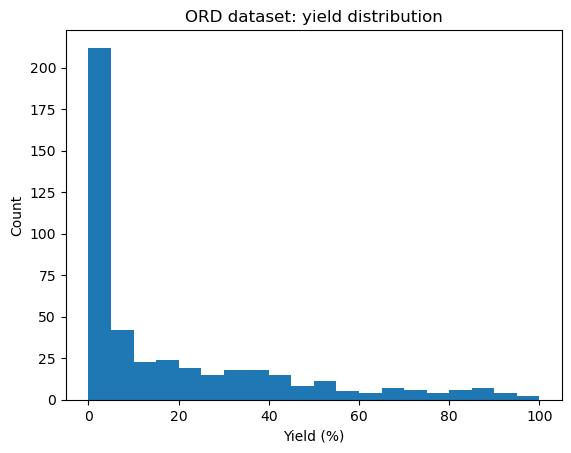

In [10]:
import matplotlib.pyplot as plt

plt.hist(yields, bins=20)
plt.xlabel("Yield (%)")
plt.ylabel("Count")
plt.title("ORD dataset: yield distribution")
plt.show()


In [11]:
min(yields), sum(y==0 for y in yields), max(yields)


(0.0, 108, 100.0)

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
def get_smiles_by_role(reaction, role_name):
    smiles = []
    for inp in reaction.inputs.values():
        for comp in inp.components:
            role = comp.DESCRIPTOR.fields_by_name["reaction_role"].enum_type.values_by_number[comp.reaction_role].name
            if role == role_name:
                for ident in comp.identifiers:
                    itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
                    if itype == "SMILES":
                        smiles.append(ident.value)
    return list(dict.fromkeys(smiles))


def get_product_smiles(reaction):
    smiles = []
    for outcome in reaction.outcomes:
        for product in outcome.products:
            if product.is_desired_product:
                for ident in product.identifiers:
                    itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
                    if itype == "SMILES":
                        smiles.append(ident.value)
    return list(dict.fromkeys(smiles))






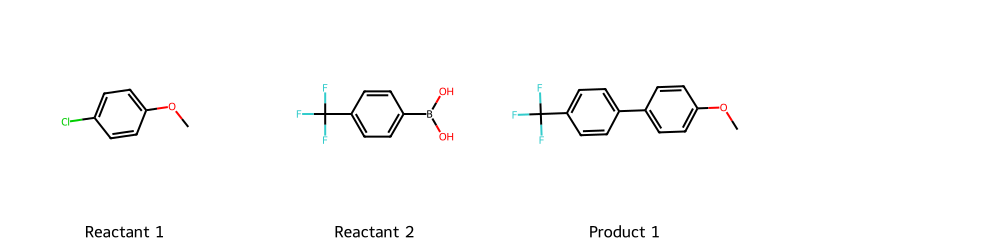

In [17]:
r = dataset.reactions[0] #90, 180, 270, 360

reactant_smiles = get_smiles_by_role(r, "REACTANT")
product_smiles  = get_product_smiles(r)

reactant_mols = [Chem.MolFromSmiles(s) for s in reactant_smiles]
product_mols  = [Chem.MolFromSmiles(s) for s in product_smiles]

mols   = reactant_mols + product_mols
legends = [f"Reactant {i+1}" for i in range(len(reactant_mols))] + \
          [f"Product {i+1}" for i in range(len(product_mols))]

Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,250), legends=legends)


=== LIGAND(S) FOR THIS REACTION ===
1) CPhos
   SMILES: CN(c1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)N(C)C)C


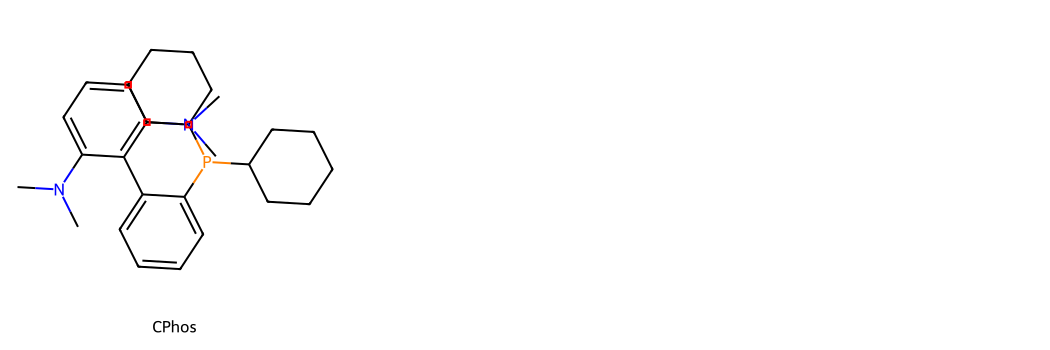

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

r = dataset.reactions[0]  

def enum_name(msg, field_name, value):
    enum_desc = msg.DESCRIPTOR.fields_by_name[field_name].enum_type
    return enum_desc.values_by_number[value].name

# collect ligands (CATALYST components except Ni source)
ligands = []  # (name, smiles)

for inp in r.inputs.values():
    for comp in inp.components:
        role = enum_name(comp, "reaction_role", comp.reaction_role)
        if role != "CATALYST":
            continue

        name, smiles = None, None
        for ident in comp.identifiers:
            idtype = enum_name(ident, "type", ident.type)
            if idtype == "NAME":
                name = ident.value
            elif idtype == "SMILES":
                smiles = ident.value

        # skip Ni source, keep ligand
        if name and "Ni" in name:
            continue
        if smiles:
            ligands.append((name if name else "Ligand", smiles))

# deduplicate by SMILES
seen = set()
uniq = []
for name, smi in ligands:
    if smi not in seen:
        seen.add(smi)
        uniq.append((name, smi))

# PRINT
print("=== LIGAND(S) FOR THIS REACTION ===")
if not uniq:
    print("No ligand recorded for this reaction index.")
else:
    for i, (name, smi) in enumerate(uniq, 1):
        print(f"{i}) {name}")
        print(f"   SMILES: {smi}")

    # VISUALIZE (force display)
    mols = [Chem.MolFromSmiles(smi) for _, smi in uniq]
    legends = [name for name, _ in uniq]
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(350, 350), legends=legends)
    display(img)


In [28]:
r = dataset.reactions[0]

def enum_name(msg, field_name, value):
    # returns the string name of an enum value (e.g., "REACTION_TYPE")
    enum_desc = msg.DESCRIPTOR.fields_by_name[field_name].enum_type
    return enum_desc.values_by_number[value].name

print("="*60)
print("ORD REACTION SUMMARY")
print("="*60)

# Reaction type (identifier)
for ident in r.identifiers:
    itype = enum_name(ident, "type", ident.type)
    if itype == "REACTION_TYPE":
        print("Reaction type:", ident.value)

print("\n--- INPUTS ---")
for key, inp in r.inputs.items():
    print(f"\nInput key: {key}")
    for comp in inp.components:
        role = enum_name(comp, "reaction_role", comp.reaction_role)
        print("  Role:", role)

        for ident in comp.identifiers:
            idtype = enum_name(ident, "type", ident.type)
            print(f"  Identifier ({idtype}): {ident.value}")

        if comp.HasField("amount"):
            if comp.amount.HasField("moles"):
                units = enum_name(comp.amount.moles, "units", comp.amount.moles.units)
                print(f"  Amount: {comp.amount.moles.value} {units}")
            if comp.amount.HasField("volume"):
                units = enum_name(comp.amount.volume, "units", comp.amount.volume.units)
                print(f"  Volume: {comp.amount.volume.value} {units}")

print("\n--- CONDITIONS ---")
if r.HasField("conditions") and r.conditions.HasField("temperature") and r.conditions.temperature.HasField("setpoint"):
    units = enum_name(r.conditions.temperature.setpoint, "units", r.conditions.temperature.setpoint.units)
    print(f"Temperature: {r.conditions.temperature.setpoint.value} {units}")

print("\n--- OUTCOMES ---")
for outcome in r.outcomes:
    if outcome.HasField("reaction_time"):
        units = enum_name(outcome.reaction_time, "units", outcome.reaction_time.units)
        print(f"Reaction time: {outcome.reaction_time.value} {units}")

    for product in outcome.products:
        # product identifiers
        for ident in product.identifiers:
            idtype = enum_name(ident, "type", ident.type)
            if idtype == "SMILES":
                print("Product SMILES:", ident.value)

        # measurements (yield)
        for m in product.measurements:
            mtype = enum_name(m, "type", m.type)
            if mtype == "YIELD" and m.HasField("percentage"):
                print(f"Yield: {m.percentage.value} %")

print("="*60)


ORD REACTION SUMMARY
Reaction type: Ni-catalyzed C(sp2)-C(sp2) Suzuki-Miyaura coupling

--- INPUTS ---

Input key: aryl chloride in dioxane
  Role: REACTANT
  Identifier (SMILES): ClC1=CC=C(OC)C=C1
  Amount: 8.0 MICROMOLE
  Role: SOLVENT
  Identifier (NAME): dioxane
  Identifier (SMILES): C1COCCO1
  Volume: 44.0 MICROLITER

Input key: boronic acid + water in dioxane
  Role: REACTANT
  Identifier (SMILES): OB(O)C1=CC=C(C(F)(F)F)C=C1
  Amount: 16.0 MICROMOLE
  Role: REAGENT
  Identifier (NAME): water
  Identifier (SMILES): O
  Amount: 40.0 MICROMOLE
  Role: SOLVENT
  Identifier (NAME): dioxane
  Identifier (SMILES): C1COCCO1
  Volume: 40.0 MICROLITER

Input key: Ni(cod)2 + phosphine ligand in dioxane
  Role: CATALYST
  Identifier (NAME): Ni(cod)2
  Identifier (SMILES): C1=C\CC/C=C\CC/1.C1=C\CC/C=C\CC/1.[Ni]
  Identifier (CAS_NUMBER): 1295-35-8
  Amount: 0.1599999964237213 MICROMOLE
  Role: SOLVENT
  Identifier (NAME): dioxane
  Identifier (SMILES): C1COCCO1
  Volume: 16.0 MICROLITER
  Ro

In [33]:
def get_yield(r):
    # returns the first YIELD percentage it finds (or None)
    for outcome in r.outcomes:
        for product in outcome.products:
            for m in product.measurements:
                mtype = m.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[m.type].name
                if mtype == "YIELD" and m.HasField("percentage"):
                    return float(m.percentage.value)
    return None

def catalyst_names(r):
    names = []
    for inp in r.inputs.values():
        for comp in inp.components:
            role = comp.DESCRIPTOR.fields_by_name["reaction_role"].enum_type.values_by_number[comp.reaction_role].name
            if role == "CATALYST":
                for ident in comp.identifiers:
                    itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
                    if itype == "NAME":
                        names.append(ident.value)
    return sorted(set(names))

for r in dataset.reactions[:450]:
    print(get_yield(r), catalyst_names(r))


3.0 ['CPhos', 'Ni(cod)2']
67.0 ['CyJohnPhos', 'Ni(cod)2']
2.0 ['Ni(cod)2', 'PAd3']
2.0 ['Ni(cod)2', 'PtBu3']
9.0 ['Ni(cod)2', 'PAd2nBu, CataCXium A']
38.0 ['Ni(cod)2', 'PCy3']
1.0 ['Ni(cod)2', 'PtBu2neopentyl']
25.0 ['Ni(cod)2', 'PtBu2Me']
37.0 ['Ni(cod)2', 'PnBu3']
31.0 ['Ni(cod)2', 'PEt3']
8.0 ['Ni(cod)2', 'PMe3']
2.0 ['Ni(cod)2', 'PtBu2Cy']
9.0 ['Ni(cod)2', 'PtBuCy2']
88.0 ['NPh-Pyrrole-PCy2, CataCXiumPCy', 'Ni(cod)2']
0.0 ['Ni(cod)2', 'P(26OMePh)3']
3.0 ['Ni(cod)2', 'PAd2Bn, cataCXium Abn']
67.0 ['Ni(cod)2', 'PBn3']
42.0 ['Ni(cod)2', 'PCy2Ph']
12.0 ['Ni(cod)2', 'PCyp3']
20.0 ['Ni(cod)2', 'PiPr3']
60.0 ['Ni(cod)2', 'PmTol3']
10.0 ['Ni(cod)2', 'PnButBu2']
9.0 ['Ni(cod)2', 'tBuBrettPhos']
2.0 ['Ni(cod)2', 'tBuXPhos']
0.0 ['Ni(cod)2', 'RockPhos']
1.0 ['JackiePhos = (35CF3)2PhBrettPhos', 'Ni(cod)2']
31.0 ['Ni(cod)2', 'PPh2(4-Me-Ph)']
15.0 ['Ni(cod)2', 'P(3-FPh)3']
0.0 ['Ni(cod)2', 'P(CH2CH2CN)3']
90.0 ['Ni(cod)2', 'PCyp(3,5-tBu2-Ph)2']
86.0 ['Ni(cod)2', 'PCy(3,5-tBu2-Ph)2']
41.0 ['Ni(co

In [20]:
r0 = dataset.reactions[0]
base = sorted(get_smiles_by_role(r0, "REACTANT"))

for i, r in enumerate(dataset.reactions):
    rs = sorted(get_smiles_by_role(r, "REACTANT"))
    if rs != base:
        print("First different reaction index:", i)
        print("Reactants:", rs)
        break


First different reaction index: 90
Reactants: ['ClC1=CC=C(OC)C=C1', 'OB(O)C1=C(C)C=C(C)C=C1C']


In [42]:
def rxn_signature(r):
    reactants = tuple(sorted(get_smiles_by_role(r, "REACTANT")))
    products  = tuple(sorted(get_product_smiles(r)))
    return (reactants, products)

seen = set()
unique = []

for i, r in enumerate(dataset.reactions):
    sig = rxn_signature(r)
    if sig not in seen and sig[0] and sig[1]:
        seen.add(sig)
        unique.append((i, sig[0], sig[1]))
    if len(unique) == 10:
        break

for i, reacts, prods in unique:
    print("\nIndex:", i)
    print("Reactants SMILES:", reacts)
    print("Products  SMILES:", prods)



Index: 0
Reactants SMILES: ('ClC1=CC=C(OC)C=C1', 'OB(O)C1=CC=C(C(F)(F)F)C=C1')
Products  SMILES: ('FC(C(C=C1)=CC=C1C2=CC=C(OC)C=C2)(F)F',)

Index: 90
Reactants SMILES: ('ClC1=CC=C(OC)C=C1', 'OB(O)C1=C(C)C=C(C)C=C1C')
Products  SMILES: ('CC1=CC(C)=CC(C)=C1C2=CC=C(OC)C=C2',)

Index: 180
Reactants SMILES: ('ClC1=CC=C(OC)C=C1', 'OB(O)C1=CC=C(C(OCC)=O)C=C1')
Products  SMILES: ('O=C(C1=CC=C(C2=CC=C(OC)C=C2)C=C1)OCC',)

Index: 270
Reactants SMILES: ('ClC1=CC=C(C(F)(F)F)C=C1', 'OB(O)C1=CC=C(OC)C=C1')
Products  SMILES: ('FC(C(C=C1)=CC=C1C2=CC=C(OC)C=C2)(F)F',)

Index: 360
Reactants SMILES: ('ClC1=CC=C(OC)C=C1', 'OB(O)C1=CC=CC=C1')
Products  SMILES: ('COC1=CC=C(C2=CC=CC=C2)C=C1',)


In [35]:
from collections import defaultdict
import numpy as np

ligand_yields = defaultdict(list)

for r in dataset.reactions:
    y = get_yield(r)
    if y is None:
        continue

    cats = catalyst_names(r)
    ligands = [c for c in cats if c != "Ni(cod)2"]
    if not ligands:
        continue

    ligand_yields[ligands[0]].append(float(y))


In [38]:
avg_yields = {
    ligand: np.mean(ys)
    for ligand, ys in ligand_yields.items()
    if len(ys) >= 2   # optional: avoid single-measure noise
}

# Sort by average yield
sorted_ligands = sorted(avg_yields.items(), key=lambda x: x[1])


In [40]:
worst = sorted_ligands[0]
best = sorted_ligands[-1]

mid = sorted_ligands[len(sorted_ligands)//2 - 2 : len(sorted_ligands)//2 + 2]

selected = [worst] + mid + [best]

labels = [l for l, _ in selected]
values = [v for _, v in selected]


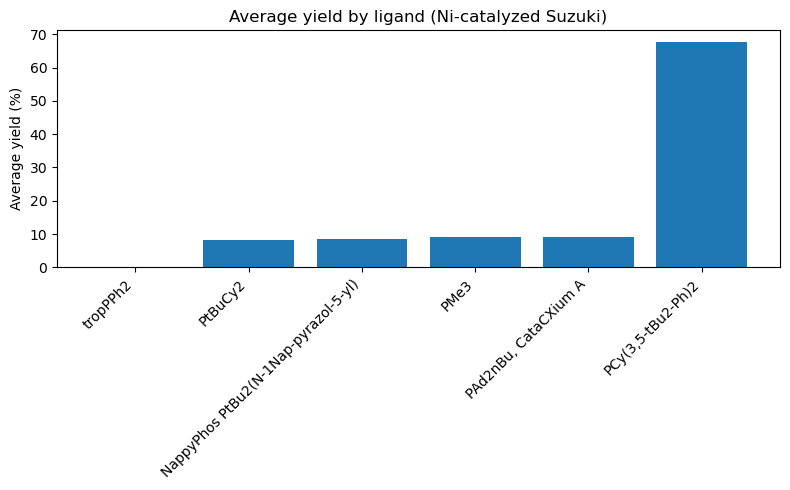

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.ylabel("Average yield (%)")
plt.title("Average yield by ligand (Ni-catalyzed Suzuki)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
